In [24]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### file hierarchy and database connection vars

In [2]:
# directory & file hierarchy
iterationName = 'e1'
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['E1c']

### render out all pngs you can find!

In [15]:
really_run = 0
if really_run:
    final_images = coll.find({'dataType':'finalImage'}).sort('time')
    imsize = 224
    for rec in final_images:
        imgData = rec['imgData'];
        filestr = base64.b64decode(imgData)
        if rec['time']> 1510252452134: ## this is the timepoint after which real data started getting collected
            if 'age' in rec.keys():
                category_dir = os.path.join(sketch_dir,rec['category'])
                if not os.path.exists(category_dir):
                    os.makedirs(category_dir)
                fname = os.path.join(category_dir,'{}_sketch_{}_{}.png'.format(rec['category'], rec['age'],rec['sessionId']))
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))


### Preprocessing data

Notes:

The collection that contains the data we will analyze for VSS is called 'E1c'.
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".

In [4]:
experiment_name = 'E1c'
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
practice_categories = ['circle','triangle']
print 'We currently have {} valid sessions.'.format(len(valid_sessions))

We currently have 50 valid sessions.


In [16]:
really_run_this = 0
if really_run_this:
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    age = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    for s in valid_sessions:
    #     print 'Analyzing {}'.format(s)
        image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:
            if imrec['category'] not in practice_categories: ## don't save practice category trials
                stroke_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                  {'sessionId':s}, 
                                                  {'dataType':'stroke'},
                                                  {'trialNum': imrec['trialNum']}]}).sort('time')   
                if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                    session_id.append(imrec['sessionId'])        
                    trial_num.append(imrec['trialNum']) 
                    category.append(imrec['category'])
                    age.append(imrec['age'])
                    png.append(imrec['imgData'])
                    submit_time.append(imrec['time'])
                    submit_date.append(imrec['date'])
                    filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], imrec['age'],imrec['sessionId'])))
                    num_strokes.append(stroke_recs.count())
                    _svg = [] # this keeps track of the strokes from THIS final image
                    _svg_times = []
                    for strec in stroke_recs:
                        _svg.append(strec['svg'])
                        _svg_times.append(strec['time'])
                    draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                    svg.append(_svg)
                    svg_times.append(_svg_times)

In [7]:
if really_run_this:
    X = pd.DataFrame([session_id,trial_num,category,age,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','trial_num','category','age','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration']

In [8]:
def get_bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

if really_run_this:


    ## add mean pixel intensity (amount of ink spilled) & bounding box coords 
    mean_intensity = []
    bounding_box = []
    imsize = 100
    numpix = imsize**2
    thresh = 250
    for i,_d in X.iterrows():
        imgData = _d['png']
        filestr = base64.b64decode(imgData)
        fname = os.path.join('sketch.png')
        with open(fname, "wb") as fh:
            fh.write(imgData.decode('base64'))
        im = Image.open(fname).resize((imsize,imsize))
        _im = np.array(im)
        mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
        # bounding box part
        rmin, rmax, cmin, cmax = get_bounding_box(np.array(Image.open(fname)))
        bounding_box.append(tuple((rmin, rmax, cmin, cmax)))

    ## add to dataframe    
    X = X.assign(mean_intensity=pd.Series(mean_intensity).values)
    X = X.assign(bounding_box=pd.Series(bounding_box).values)
    
    # save out csv
    X.to_csv('../preprocessed_data/museumdraw_{}_data.csv'.format(experiment_name))


### load drawing metadata csv back in

In [20]:
data_path = '../preprocessed_data/museumdraw_E1c_imageData.csv'
X = pd.read_csv(data_path)

### Basic visualizations

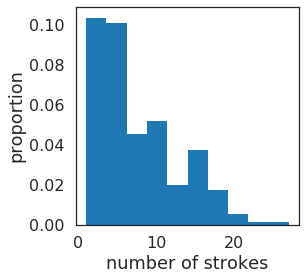

In [22]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

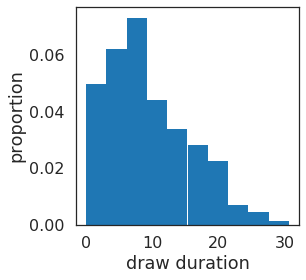

In [23]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

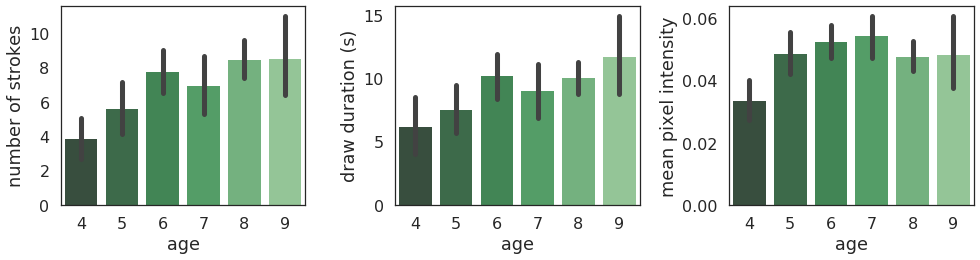

In [28]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.subplot(1,3,3)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
plt.ylabel('mean pixel intensity')

plt.tight_layout()

### vgg feature analysis 

In [18]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [19]:
# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[1]

# extract metadata
path_to_sketches = '../sketches'
sketch_paths = sorted(list_files(path_to_sketches))

In [20]:
## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

Number of sketch paths = 243


#### extract features

In [72]:
## extract features
layers = ['P1','P2','P3','P4','P5','FC6','FC7']
layer_ind = 6 ### fc6 = 5, fc7 = 6
extractor = FeatureExtractor(sketch_paths,layer=layer_ind)
Features, Labels, Ages, Sessions = extractor.extract_feature_matrix()

Batch 1
Batch 2
Batch 3
Batch 4
stopped!


In [73]:
## handle trials where we didn't have age information
def convert_age(Ages):
    ages = []
    for a in Ages:
        if len(a)>0:
            ages.append(int(a))
        else:
            ages.append(-1)
    return ages
Ages = convert_age(Ages)

In [74]:
# organize metadata into dataframe
Y = pd.DataFrame([Labels,Ages,Sessions])
Y = Y.transpose()
Y.columns = ['label','age','session']
Y.to_csv('METADATA_{}.csv'.format(layers[layer_ind]))

In [76]:
Y.age==-1

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18      True
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
213    False
214    False
215    False
216    False
217    False
218    False
219    False
220    False
221    False
222    False
223    False
224    False
225    False
226    False
227    False
228    False
229    False
230    False
231    False
232    False
233    False
234    False
235    False
236    False
237    False
238    False
239    False
240    False
241    False
242     True
Name: age, Length: 243, dtype: bool

#### preprocessing

In [26]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def preprocess_features(Features, Y):
    # normalize feature vectors & plot full image-level similarity matrix
    _Y = Y.sort_values(['label','age','session'])
    inds = np.array(_Y.index)
    _Features = normalize(Features[inds])
    return _Features, _Y

def save_features(Features, Labels, X, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']
    np.save('FEATURES_{}.npy'.format(layers[layer_num]), Features)
    np.save('LABELS.npy', Labels)
    X.to_csv('METADATA.csv')
    return layer_num

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
#     plt.close()        

### preprocess features

In [95]:
## preprocess
_Features, _Y = preprocess_features(Features, Y)


## remove data where you dont have age information
def remove_nans(Features, Y):
    ind = Y.index[(Y['age'] > 0)]
    _Y = Y.loc[ind]
    _Features = Features[ind.tolist()]
    return _Features, _Y

_Features, _Y = remove_nans(_Features, _Y)

# reset pandas dataframe index
_Y = _Y.reset_index()

### quick classification test

In [96]:
#### Quick classification test
FEAT = _Features
LABELS = _Y.label.values
AGES = _Y.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 0
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.466666666667


In [112]:
## see how recognizability changes with age?

scores = []
num_samples = []
age_range = np.arange(4,11)


# width of moving window in # of trials    
window_size = 2
lb = int(min(_Y.age.values))
ub = int(max(_Y.age.values))
num_windows = ub-lb-window_size+2 ##     

for n in np.arange(num_windows):
    start = lb + n
    end = lb + n + window_size
    ind = _Y.index[(_Y['age'] >= start) & (_Y['age'] < end)]
    meta = _Y.loc[ind]
    subFeat = _Features[ind.tolist()]

    FEAT = subFeat
    LABELS = meta.label.values

    # single train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        FEAT, LABELS, test_size=0.4, random_state=0)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
    num_samples.append(len(LABELS))
    scores.append(clf.score(X_test, y_test))
    

3-4y 27 0.181818181818
4-5y 70 0.321428571429
5-6y 91 0.27027027027
6-7y 73 0.533333333333
7-8y 74 0.266666666667
8-9y 61 0.24
9-10y 48 0.05


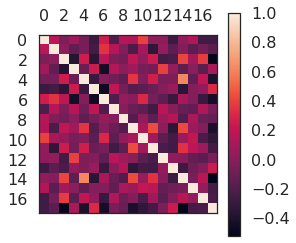

In [110]:
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = _Y.label.values
means = get_class_means(_Features, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()

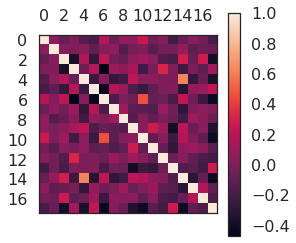

In [114]:
## mayve try filtering by age to see if RDM makes any more sense?
ind = _Y.index[_Y['age'] > 6]
subY = _Y.loc[ind]
subFeat = _Features[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()
CORRMAT1 = CORRMAT

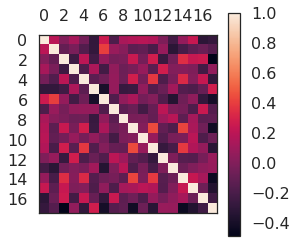

In [115]:
## mayve try filtering by age to see if RDM makes any more sense?
ind = _Y.index[_Y['age'] <= 6]
subY = _Y.loc[ind]
subFeat = _Features[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()
CORRMAT2 = CORRMAT

In [116]:
import scipy.stats as stats
stats.spearmanr(np.ravel(CORRMAT1),np.ravel(CORRMAT2))

SpearmanrResult(correlation=0.60024679767978673, pvalue=4.2618931682420408e-33)